In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Storico():
    
    def __init__(self, nomefile, point_value):
        self.nomefile = nomefile
        self.point_value = point_value
        Date, Open, High, Low, Close = self.carica_file_pandas()
        self.Date = Date
        self.Open = Open
        self.High = High
        self.Low = Low
        self.Close = Close        
            
    def carica_file_pandas(self):
        df = pd.read_csv(self.nomefile, 
                 usecols=['Date','Time','Open','High','Low','Close'], 
                 parse_dates=[['Date', 'Time']], )
        df.index = df['Date_Time']
    
        print("Il file", self.nomefile, "contiene:", df.shape[0], "record")
        
        return df['Date_Time'], df['Open'], df['High'], df['Low'], df['Close']
    
    def daily_open(self, offset):
        a = pd.DataFrame(index=self.Open.index)
        a['new'] = self.Open.resample('D', origin='start').first().shift(offset)
        a = a.fillna(method = 'ffill')
        return pd.Series(a['new'])
    
    def daily_high(self, offset):
        a = pd.DataFrame(index=self.High.index)
        a['new'] = self.High.resample('D', origin='start').max().shift(offset)
        a = a.fillna(method = 'ffill')
        return pd.Series(a['new'])
    
    def daily_low(self, offset):
        a = pd.DataFrame(index=self.Open.index)
        a['new'] = self.Low.resample('D', origin='start').min().shift(offset)
        a = a.fillna(method = 'ffill')
        return pd.Series(a['new'])
    
    def daily_close(self, offset):
        a = pd.DataFrame(index=self.Close.index)
        a['new'] = self.Close.resample('D', origin='start').last().shift(offset)
        a = a.fillna(method = 'ffill')
        return pd.Series(a['new'])
    
class Trading_System():
    
    def __init__(self, enter_rules, exit_rules, enter_level, exit_level):
        self.enter_rules = enter_rules
        self.exit_rules = exit_rules
        self.enter_level = enter_level
        self.exit_level = exit_level
        
        self.entry_price = pd.DataFrame() 
        self.exit_price = pd.DataFrame() 

        self.marketposition = pd.DataFrame() 
        self.closed_equity = pd.DataFrame() 
        self.operations = pd.DataFrame()
        self.events_in = pd.DataFrame() 
        self.events_out = pd.DataFrame() 
        
    def apply(self, data):
        equity = pd.Series(np.zeros(len(self.enter_rules)),index=self.enter_rules.index)
        marketposition = pd.Series(np.zeros(len(self.enter_rules)),index=self.enter_rules.index)  
        operations = pd.Series(np.zeros(len(self.enter_rules)), index=self.enter_rules.index)
        operations = operations.replace(0, np.nan)
        events_in = pd.Series([''] * len(self.enter_rules),index=self.enter_rules.index)  
        events_out = pd.Series([''] * len(self.enter_rules),index=self.enter_rules.index)     
        entry_price = pd.Series(np.zeros(len(self.enter_rules)),index=self.enter_rules.index) 
        exit_price = pd.Series(np.zeros(len(self.enter_rules)),index=self.enter_rules.index) 
            
        point_value = data.point_value
        last_equity = 0            
        i=0
        while i<len(self.enter_rules):

        # Ingresso
            if i>0 and self.enter_rules[i-1]==True and marketposition[i-1]==0:
                if data.Low[i] <= self.enter_level[i] and data.Open[i] >= self.enter_level[i]:
                    entry_price[i] = self.enter_level[i]
                    events_in[i] = "enter_long"          
                    marketposition[i] = 1        
                    last_equity = equity[i - 1]        

                else:
                    marketposition[i] = 0

            if marketposition[i-1]==1:
                entry_price[i] = entry_price[i-1]
                
        # Uscita
            if i>0 and self.exit_rules[i-1]==True and marketposition[i-1]==1:
                if data.High[i] >= self.exit_level[i] and data.Open[i] <= self.exit_level[i]:
                    exit_price[i] = self.exit_level[i]
                    events_out[i] = "exit_long"  ### in-out
                    marketposition[i] = 0
                    operations[i] = ((exit_price[i]-entry_price[i])*1 * point_value)
                else:
                    marketposition[i] = 1
            i+=1
        self.entry_price = entry_price
        self.exit_price = exit_price
        self.marketposition = marketposition
        self.events_out = events_out 
        self.events_in = events_in 
        self.operations = operations
        self.closed_equity = operations.fillna(0).cumsum()

In [3]:
class Trading_System():
    
    def __init__(self, enter_rules, exit_rules, enter_level, exit_level):
        self.enter_rules = enter_rules
        self.exit_rules = exit_rules
        self.enter_level = enter_level
        self.exit_level = exit_level
        
        self.entry_price = pd.DataFrame() 
        self.exit_price = pd.DataFrame() 

        self.marketposition = pd.DataFrame() 
        self.closed_equity = pd.DataFrame() 
        self.operations = pd.DataFrame()
        self.events_in = pd.DataFrame() 
        self.events_out = pd.DataFrame() 
        
    def apply(self, data):
        equity = pd.Series(np.zeros(len(self.enter_rules)),index=self.enter_rules.index)
        marketposition = pd.Series(np.zeros(len(self.enter_rules)),index=self.enter_rules.index)  
        operations = pd.Series(np.zeros(len(self.enter_rules)), index=self.enter_rules.index)
        operations = operations.replace(0, np.nan)
        events_in = pd.Series([''] * len(self.enter_rules),index=self.enter_rules.index)  
        events_out = pd.Series([''] * len(self.enter_rules),index=self.enter_rules.index)     
        entry_price = pd.Series(np.zeros(len(self.enter_rules)),index=self.enter_rules.index) 
        exit_price = pd.Series(np.zeros(len(self.enter_rules)),index=self.enter_rules.index) 
            
        point_value = data.point_value
        last_equity = 0            
        i=0
        while i<len(self.enter_rules):

        # Ingresso
            if i>0 and self.enter_rules[i-1]==True and marketposition[i-1]==0:
                if data.Low[i] <= self.enter_level[i] and data.Open[i] >= self.enter_level[i]:
                    entry_price[i] = self.enter_level[i]
                    events_in[i] = "enter_long"          
                    marketposition[i] = 1        
                    last_equity = equity[i - 1]        

                else:
                    marketposition[i] = 0

            if marketposition[i-1]==1:
                entry_price[i] = entry_price[i-1]
                
        # Uscita
            if i>0 and self.exit_rules[i-1]==True and marketposition[i-1]==1:
                if data.High[i] >= self.exit_level[i] and data.Open[i] <= self.exit_level[i]:
                    exit_price[i] = self.exit_level[i]
                    events_out[i] = "exit_long"  ### in-out
                    marketposition[i] = 0
                    operations[i] = ((exit_price[i]-entry_price[i])*1 * point_value)
                else:
                    marketposition[i] = 1
            i+=1
        self.entry_price = entry_price
        self.exit_price = exit_price
        self.marketposition = marketposition
        self.events_out = events_out 
        self.events_in = events_in 
        self.operations = operations
        self.closed_equity = operations.fillna(0).cumsum()

NB: Historical data provided in this file is not from real market, was generated just for this poject 

Il file OHLC_1minute.txt contiene: 1921 record


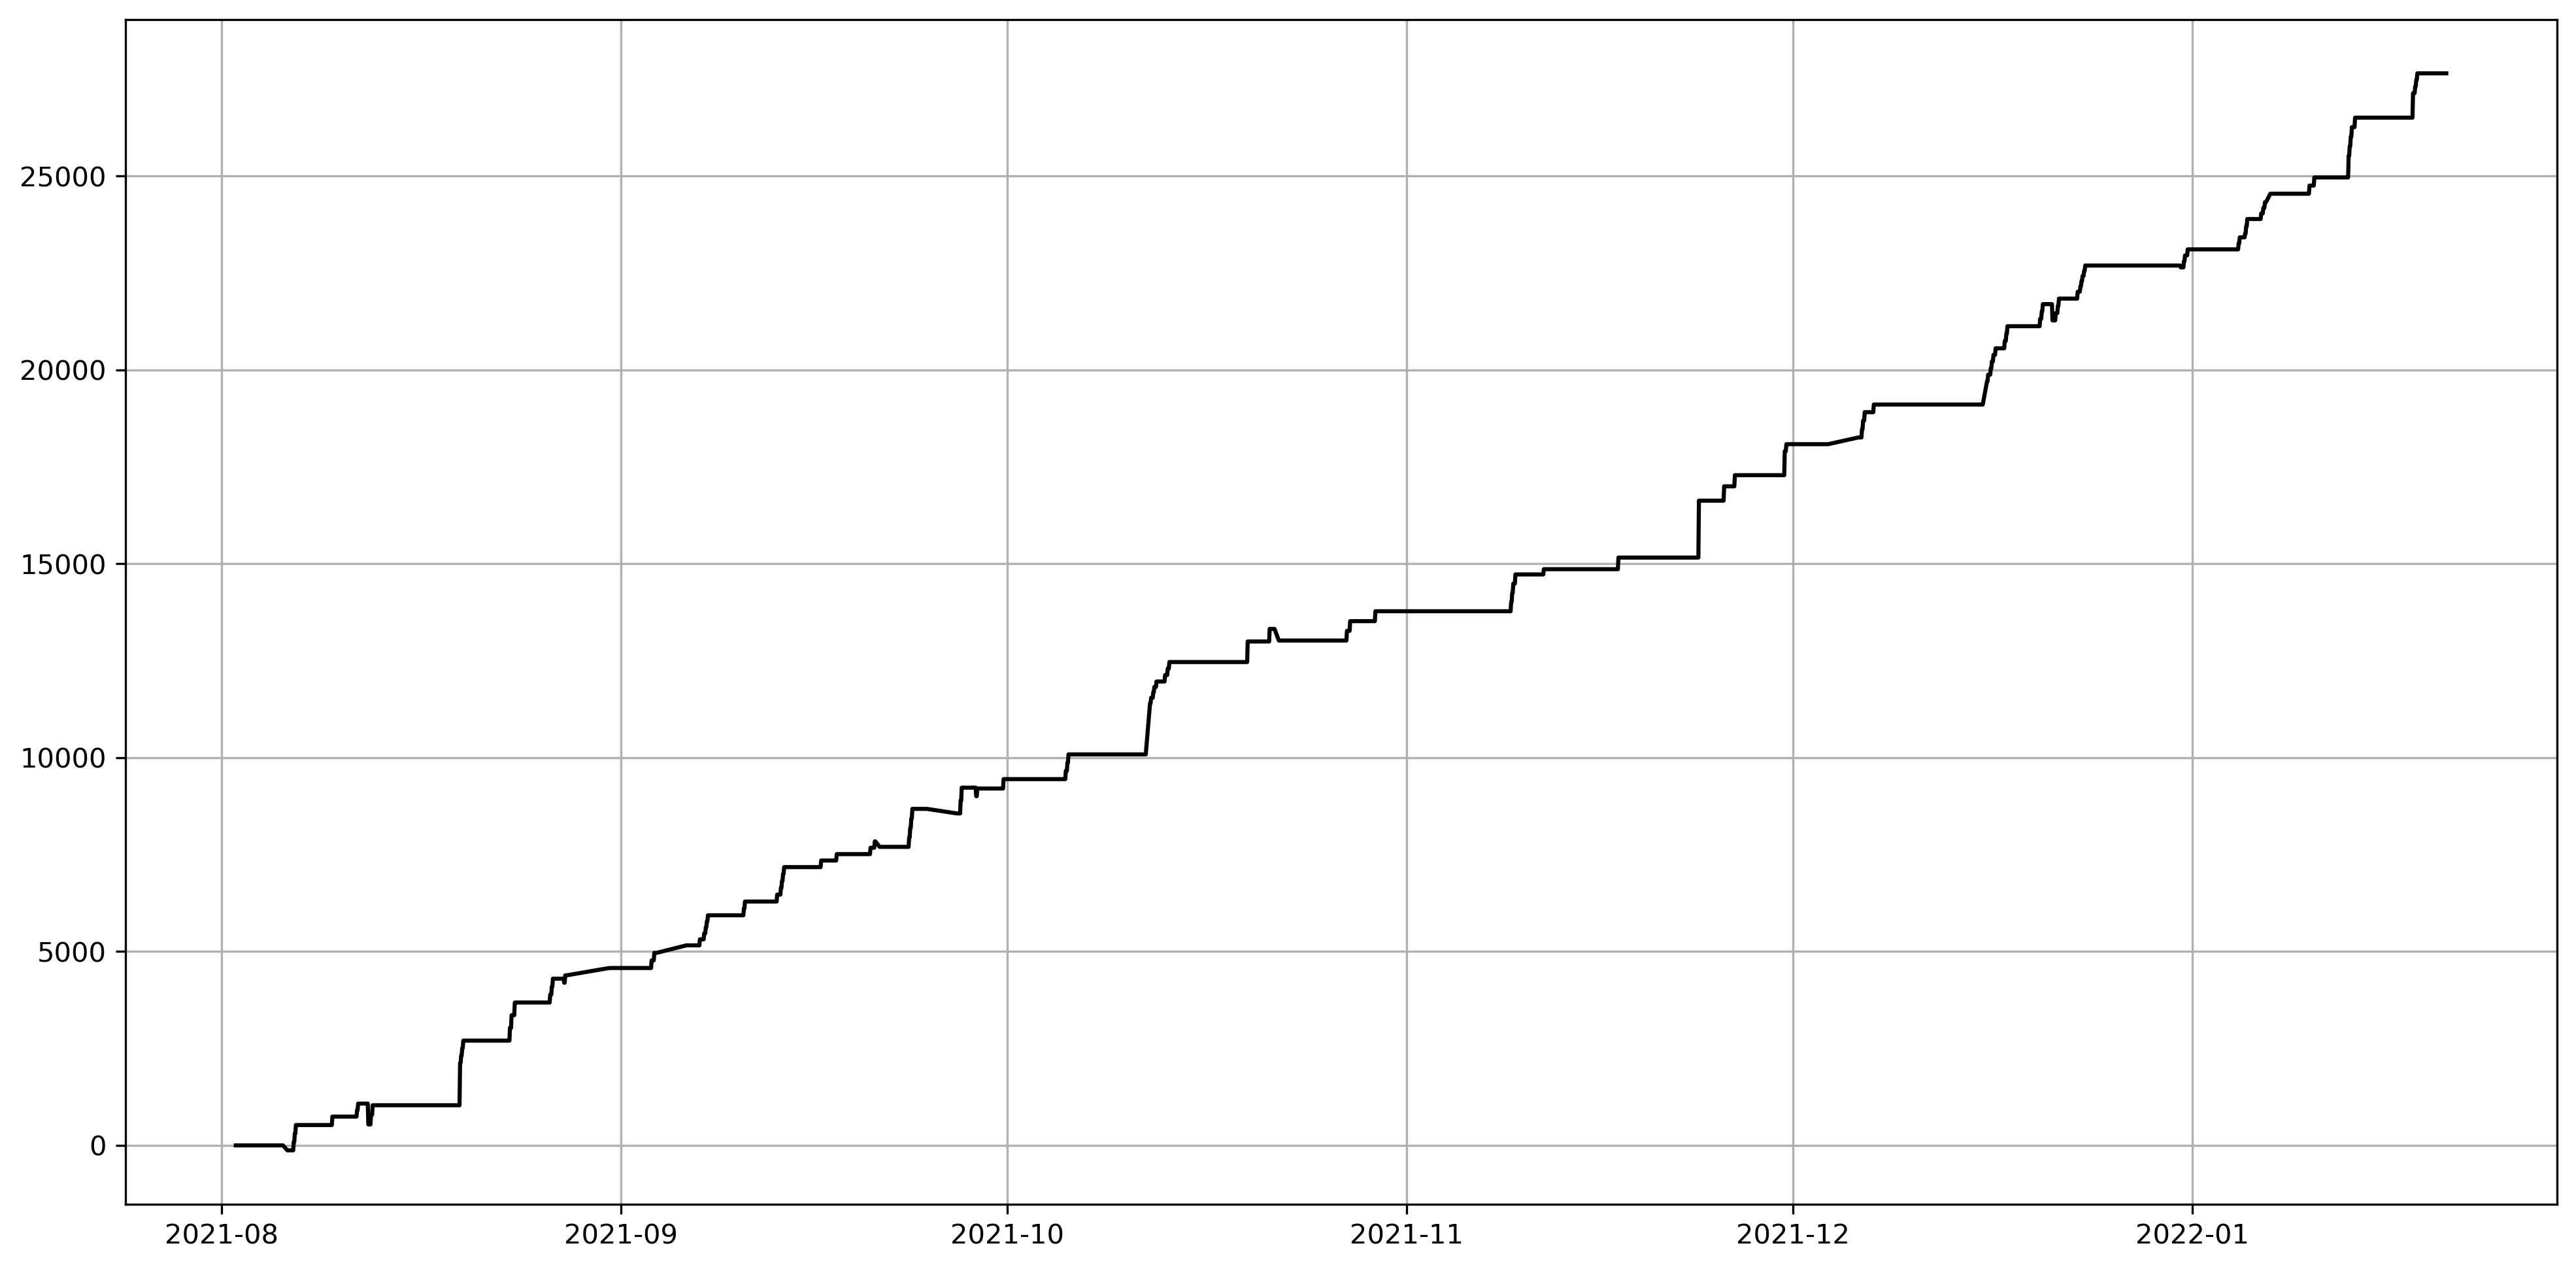

In [6]:
spread = Storico("OHLC_1minute.txt", 1)

rangeD1 = (spread.daily_high(1) - spread.daily_low(1))

enter_level = spread.daily_close(1)- rangeD1*0.4
exit_level = spread.daily_close(1)- rangeD1*0.2

enter_rules = (spread.Close >= spread.Low)
exit_rules = (spread.Close >= spread.Low)

ts = Trading_System(enter_rules, exit_rules, enter_level, exit_level)
ts.apply(spread)

plt.figure(figsize=(16,8), dpi=300)
plt.plot(ts.closed_equity, color='black')
plt.grid(True)
plt.show()